In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_train = pd.read_csv('train.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df_train['Survived'].mean()

0.38383838383838381

In [6]:
df_test = pd.read_csv('test.csv')

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [8]:
df = pd.concat([df_train, df_test]).reset_index()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
index          1309 non-null int64
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(5), object(5)
memory usage: 133.0+ KB


## Sex
* categorize

In [10]:
df['SexCode'] = df['Sex'].map({'female':0, 'male':1})

## Embarked
* 3 category, so we try one-hot encoding

In [11]:
df['Embarked'].value_counts(dropna=False)

S      914
C      270
Q      123
NaN      2
Name: Embarked, dtype: int64

In [12]:
for i in ['S', 'C', 'Q']:
    print(i, df[df['Embarked']==i]['Survived'].mean())

S 0.336956521739
C 0.553571428571
Q 0.38961038961


In [13]:
df[df['Embarked'].isnull()]

,index,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,SexCode
61,61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,0
829,829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,0


In [14]:
df[(df['Fare']>70) & (df['Pclass']==1) & (df['Survived']==1) & (df['Sex']=='female')]['Embarked'].value_counts()

C    31
S    28
Q     1
Name: Embarked, dtype: int64

In [15]:
df['Embarked'].fillna('C', inplace=True)

In [16]:
embarked = pd.get_dummies(df['Embarked'], prefix='Embarked')
df = pd.concat([df, embarked], axis=1)

## Pclass

In [17]:
pclass = pd.get_dummies(df['Pclass'], prefix='Pclass')
df = pd.concat([df, pclass], axis=1)

## Cabin
* isnull vs. notnull

In [18]:
df[df['Cabin'].isnull()]['Survived'].mean(), df[df['Cabin'].notnull()]['Survived'].mean()

(0.29985443959243085, 0.66666666666666663)

In [19]:
df['Cabin'].fillna('-', inplace=True)

In [20]:
df['CabinClass'] = df['Cabin'].apply(lambda x: x[0])

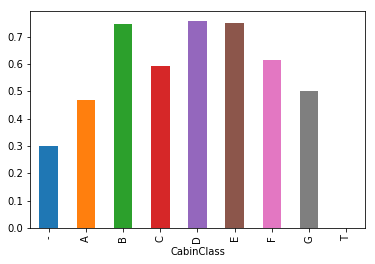

In [21]:
df.groupby('CabinClass').Survived.mean().plot('bar')

In [22]:
cabinclass = pd.get_dummies(df['CabinClass'], prefix='CabinClass')
df = pd.concat([df, cabinclass], axis=1)

## FaimlySize (Update)

In [23]:
df['FamilySize'] = df['Parch'] + df['SibSp'] + 1

## Ticket (Update) 
* TicketCount does not work well on testing set
  * but it does improve oob_score

In [24]:
df['TicketType'] = df['Ticket'].apply(lambda x: ''.join(x.split()[:-1]).replace('.', '').replace('/', '').upper())
df.loc[df[df['TicketType']==''].index, 'TicketType'] = 'NONETYPE'

In [25]:
df['TicketType'].value_counts()

NONETYPE     961
PC            92
CA            68
A5            28
SOTONOQ       24
STONO2        21
SCPARIS       19
WC            15
A4            10
FCC            9
C              8
SOC            8
SOPP           7
SCAH           4
PP             4
WEP            4
SOTONO2        3
FC             3
SWPP           2
PPP            2
SCA4           2
SC             2
SCAHBASLE      1
FA             1
AQ3            1
AS             1
LP             1
CASOTON        1
SCA3           1
STONOQ         1
SCOW           1
A2             1
AQ4            1
SOP            1
SP             1
Name: TicketType, dtype: int64

In [26]:
df['TicketTypeOQ'] = df['TicketType'].apply(lambda x: x.endswith('OQ')).astype(int)
print(df[df['TicketTypeOQ']==1].Survived.mean())
df[df['TicketTypeOQ']==1].Survived.value_counts()

0.133333333333


0.0    13
1.0     2
Name: Survived, dtype: int64

In [27]:
df['TicketTypeSO'] = df['TicketType'].apply(lambda x: x.startswith('SO')).astype(int)
print(df[df['TicketTypeSO']==1].Survived.mean())
df[df['TicketTypeSO']==1].Survived.value_counts()

0.111111111111


0.0    24
1.0     3
Name: Survived, dtype: int64

In [28]:
df['TicketTypeSTON'] = df['TicketType'].apply(lambda x: x.startswith('STON')).astype(int)
print(df[df['TicketTypeSTON']==1].Survived.mean())
df[df['TicketTypeSTON']==1].Survived.value_counts()

0.444444444444


0.0    10
1.0     8
Name: Survived, dtype: int64

In [29]:
df['TicketTypeSC'] = df['TicketType'].apply(lambda x: x.startswith('SC')).astype(int)
print(df[df['TicketTypeSC']==1].Survived.mean())
df[df['TicketTypeSC']==1].Survived.value_counts()

0.470588235294


0.0    9
1.0    8
Name: Survived, dtype: int64

In [30]:
df['TicketTypeCA'] = df['TicketType'].apply(lambda x: x=='CA').astype(int)
print(df[df['TicketTypeCA']==1].Survived.mean())
df[df['TicketTypeCA']==1].Survived.value_counts()

0.341463414634


0.0    27
1.0    14
Name: Survived, dtype: int64

In [31]:
df['TicketTypeA'] = df['TicketType'].apply(lambda x: x.startswith('A')).astype(int)
print(df[df['TicketTypeA']==1].Survived.mean())
df[df['TicketTypeA']==1].Survived.value_counts()

0.0689655172414


0.0    27
1.0     2
Name: Survived, dtype: int64

In [32]:
df['TicketTypeW'] = df['TicketType'].apply(lambda x: x.startswith('W')).astype(int)
print(df[df['TicketTypeW']==1].Survived.mean())
df[df['TicketTypeW']==1].Survived.value_counts()

0.153846153846


0.0    11
1.0     2
Name: Survived, dtype: int64

In [33]:
df['TicketNo'] = df['Ticket'].apply(lambda x: x.split()[-1])

In [34]:
mask1 = (df['TicketNo'].apply(lambda x: x.startswith('1')))# & (df['TicketNo'].apply(lambda x: len(x)==6))
df[mask1]['Survived'].mean()

0.60606060606060608

In [35]:
mask2 = (df['TicketNo'].apply(lambda x: x.startswith('2')))# & (df['TicketNo'].apply(lambda x: len(x)==6))
df[mask2]['Survived'].mean()

0.40869565217391307

In [36]:
mask = ~(mask1 | mask2)
df[mask]['Survived'].mean()

0.25116279069767444

In [37]:
df['TicketNo1'] = mask1.astype(int)
df['TicketNo2'] = mask2.astype(int)
df['TicketNoX'] = mask.astype(int)

## Name

In [38]:
df['Name'] = df['Name'].apply(lambda x: x.strip())
p = re.compile(r'^([\w,. ]+)\(([\w. ]+)\)$')
def match(x, i):
    # i = 0 or 1
    m = p.match(x)
    if m:
        return m.groups()[i]
    else:
        return (x, '')[i]
df['Name1'] = df['Name'].apply(lambda x: match(x, 0).strip())
df['Name2'] = df['Name'].apply(lambda x: match(x, 1).strip())
df['Name2Len'] =df ['Name2'].apply(lambda x: len(x.split()))

In [39]:
df['Name2Len'].value_counts()

0    1127
3      85
2      74
1      14
4       8
7       1
Name: Name2Len, dtype: int64

In [40]:
df['Name2Len'].clip(upper=1, inplace=True)

In [41]:
df.groupby('Name2Len').Survived.mean()

Name2Len
0    0.322078
1    0.776860
Name: Survived, dtype: float64

In [42]:
df['LastName'] = df['Name1'].apply(lambda x: x.split('.')[1])
df['LastNameLen'] = df['LastName'].apply(lambda x: len(x.strip().split()))
df['LastNameLen'] = df['LastNameLen'].map({1:0, 3:0, 2:1, 0:2, 4:2, 5:2, 6:2, 7:2})
df['LastNameLen'].value_counts()

1    637
0    621
2     51
Name: LastNameLen, dtype: int64

In [43]:
df.groupby('LastNameLen')['Survived'].mean()

LastNameLen
0    0.326969
1    0.407323
2    0.771429
Name: Survived, dtype: float64

In [92]:
df['Title'] = df['Name1'].apply(lambda x: x.split('.')[0].split(' ')[-1])
df['Title'] = df['Title'].map({'Lady':'Miss', 'Ms':'Miss', 'Mme':'Mrs', 'Mlle':'Miss', 'Dona':'Mrs',
                               'Jonkheer':'Master', 'Don':'Master', 'Sir':'Master', 'Capt':'Mr',
                               'Countess':'Master', 'Col':'Master', 'Major':'Master', 'Rev':'Mr',
                               'Dr':'Master', 'Mr':'Mr', 'Miss':'Miss', 'Mrs':'Mrs', 'Master':'Master'})
df['Title'] = df['Title'].map({'Mr':0, 'Master':1, 'Miss':2, 'Mrs':3})
df['Title'].value_counts()

0    766
2    265
3    199
1     79
Name: Title, dtype: int64

In [45]:
df.groupby('Title').Survived.mean()

Title
0.0    0.154580
1.0    0.545455
2.0    0.704301
3.0    0.793651
Name: Survived, dtype: float64

## Age
* there are some nan
* add feature **WithAge** (Update) 

In [46]:
df['AgeClip'] = df['Age'].clip(upper=55)
'''
age_survived = pd.pivot_table(df, values='PassengerId', columns='Survived', index='AgeClip', fill_value=0, aggfunc=len)
agegroup_survived = age_survived.groupby(pd.cut(age_survived.index, np.arange(-3, 70, 6))).sum()
agegroup_survived['rate'] = agegroup_survived[1] / (agegroup_survived[0]+agegroup_survived[1])
agegroup_survived['count'] = (agegroup_survived[0]+agegroup_survived[1])
agegroup_survived
'''
# clip at 65-year-old
df['AgeGroup'] = pd.cut(df['AgeClip'], np.arange(-3, 60, 6))
df.groupby(['AgeGroup', 'Sex']).Survived.mean()

AgeGroup  Sex   
(-3, 3]   female    0.583333
          male      0.722222
(3, 9]    female    0.666667
          male      0.428571
(9, 15]   female    0.692308
          male      0.250000
(15, 21]  female    0.707317
          male      0.112500
(21, 27]  female    0.775510
          male      0.190476
(27, 33]  female    0.767442
          male      0.192771
(33, 39]  female    0.870968
          male      0.210526
(39, 45]  female    0.666667
          male      0.194444
(45, 51]  female    0.785714
          male      0.218750
(51, 57]  female    0.937500
          male      0.121951
Name: Survived, dtype: float64

In [47]:
df.groupby(['AgeGroup', 'Sex']).PassengerId.nunique()

AgeGroup  Sex   
(-3, 3]   female     19
          male       22
(3, 9]    female     20
          male       21
(9, 15]   female     17
          male       16
(15, 21]  female     63
          male      112
(21, 27]  female     78
          male      136
(27, 33]  female     62
          male      117
(33, 39]  female     45
          male       73
(39, 45]  female     32
          male       58
(45, 51]  female     22
          male       46
(51, 57]  female     30
          male       57
Name: PassengerId, dtype: int64

In [48]:
df['AgeGroup'] = pd.cut(df['AgeClip'], np.arange(-3, 60, 6), labels=range(1, 11))

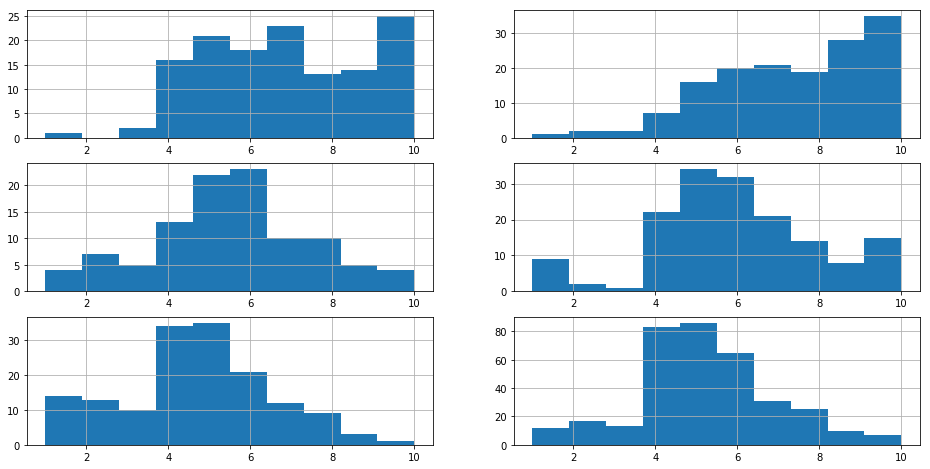

In [49]:
import matplotlib.gridspec as gridspec
plt.tight_layout()
fig = plt.figure(figsize=(16, 8)) 
gs = gridspec.GridSpec(3, 2) 

ax1 = plt.subplot(gs[0, 0])
df[(df['Pclass']==1) & (df['SexCode']==0)]['AgeGroup'].hist(ax=ax1, bins=10)
ax2 = plt.subplot(gs[0, 1])
df[(df['Pclass']==1) & (df['SexCode']==1)]['AgeGroup'].hist(ax=ax2, bins=10)
ax3 = plt.subplot(gs[1, 0], sharex=ax1)
df[(df['Pclass']==2) & (df['SexCode']==0)]['AgeGroup'].hist(ax=ax3, bins=10)
ax4 = plt.subplot(gs[1, 1], sharex=ax2)
df[(df['Pclass']==2) & (df['SexCode']==1)]['AgeGroup'].hist(ax=ax4, bins=10)
ax5 = plt.subplot(gs[2, 0], sharex=ax1)
df[(df['Pclass']==3) & (df['SexCode']==0)]['AgeGroup'].hist(ax=ax5, bins=10)
ax6 = plt.subplot(gs[2, 1], sharex=ax2)
df[(df['Pclass']==3) & (df['SexCode']==1)]['AgeGroup'].hist(ax=ax6, bins=10)

In [50]:
masks = [(df['Pclass']==1) & (df['SexCode']==0),
         (df['Pclass']==2) & (df['SexCode']==0),
         (df['Pclass']==3) & (df['SexCode']==0),
         (df['Pclass']==1) & (df['SexCode']==1),
         (df['Pclass']==2) & (df['SexCode']==1),
         (df['Pclass']==3) & (df['SexCode']==1)]
ages = [df[mask]['AgeGroup'].value_counts().idxmax() for mask in masks]
print(ages)
for mask, age in zip(masks, ages):
    df.loc[df[mask & df['Age'].isnull()].index, 'AgeGroup'] = age

[10, 6, 5, 10, 5, 5]


In [51]:
df['WoAge'] = df['Age'].isnull().astype(int)

In [116]:
agegroup = pd.get_dummies(df['AgeGroup'], prefix='AgeGroup')
df = pd.concat([df, agegroup], axis=1)

## Fare

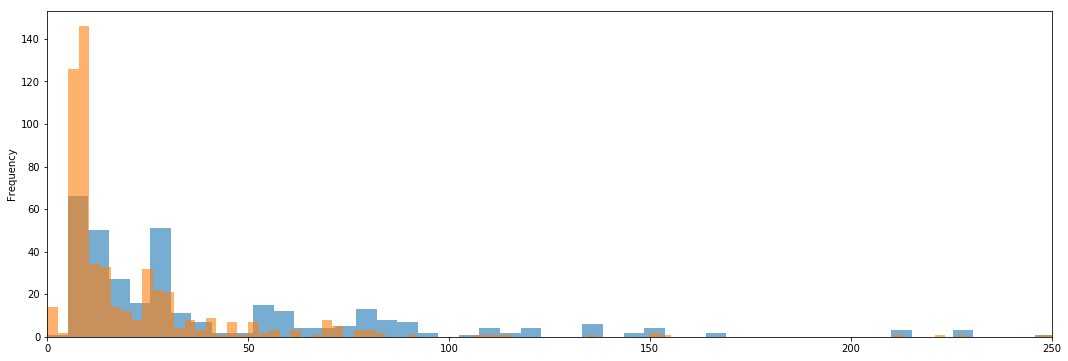

In [52]:
df[df['Survived']==1]['Fare'].plot(kind='hist', bins=100, alpha=0.6, figsize=(18,6), xlim=[0, 250])
df[df['Survived']==0]['Fare'].plot(kind='hist', bins=100, alpha=0.6)

In [53]:
for i, j in df['Fare'].value_counts().iteritems():
    print('Fare={}\tSurvivedMean={}\tCount={}'.format(i, df[df['Fare'] == i].Survived.mean(), j))

Fare=8.05	SurvivedMean=0.11627906976744186	Count=60
Fare=13.0	SurvivedMean=0.38095238095238093	Count=59
Fare=7.75	SurvivedMean=0.35294117647058826	Count=55
Fare=26.0	SurvivedMean=0.4838709677419355	Count=50
Fare=7.8958	SurvivedMean=0.02631578947368421	Count=49
Fare=10.5	SurvivedMean=0.375	Count=35
Fare=7.775	SurvivedMean=0.1875	Count=26
Fare=7.2292	SurvivedMean=0.26666666666666666	Count=24
Fare=7.925	SurvivedMean=0.4444444444444444	Count=23
Fare=26.55	SurvivedMean=0.5333333333333333	Count=22
Fare=8.6625	SurvivedMean=0.07692307692307693	Count=21
Fare=7.8542	SurvivedMean=0.23076923076923078	Count=21
Fare=7.225	SurvivedMean=0.25	Count=21
Fare=7.25	SurvivedMean=0.07692307692307693	Count=18
Fare=0.0	SurvivedMean=0.06666666666666667	Count=17
Fare=21.0	SurvivedMean=0.3333333333333333	Count=14
Fare=9.5	SurvivedMean=0.2222222222222222	Count=12
Fare=16.1	SurvivedMean=0.2222222222222222	Count=12
Fare=14.5	SurvivedMean=0.2857142857142857	Count=11
Fare=69.55	SurvivedMean=0.0	Count=11
Fare=27.7208	S

Fare=8.1375	SurvivedMean=0.0	Count=1
Fare=40.125	SurvivedMean=0.0	Count=1
Fare=34.6542	SurvivedMean=0.0	Count=1
Fare=10.5167	SurvivedMean=0.0	Count=1
Fare=7.575	SurvivedMean=nan	Count=1
Fare=27.4458	SurvivedMean=nan	Count=1
Fare=25.7417	SurvivedMean=nan	Count=1
Fare=38.5	SurvivedMean=0.0	Count=1
Fare=45.5	SurvivedMean=nan	Count=1
Fare=8.4333	SurvivedMean=0.0	Count=1
Fare=8.1583	SurvivedMean=0.0	Count=1
Fare=8.0292	SurvivedMean=1.0	Count=1
Fare=12.7375	SurvivedMean=nan	Count=1
Fare=31.6833	SurvivedMean=nan	Count=1
Fare=42.5	SurvivedMean=nan	Count=1
Fare=34.0208	SurvivedMean=0.0	Count=1
Fare=25.925	SurvivedMean=0.0	Count=1
Fare=12.65	SurvivedMean=1.0	Count=1
Fare=7.0458	SurvivedMean=0.0	Count=1
Fare=49.5	SurvivedMean=1.0	Count=1
Fare=7.7208	SurvivedMean=nan	Count=1
Fare=32.3208	SurvivedMean=0.0	Count=1
Fare=6.45	SurvivedMean=0.0	Count=1
Fare=8.3	SurvivedMean=0.0	Count=1
Fare=7.5208	SurvivedMean=0.0	Count=1
Fare=28.7125	SurvivedMean=0.0	Count=1
Fare=25.5875	SurvivedMean=0.0	Count=1
Fare=7

In [54]:
fares = [i for i, j in df['Fare'].value_counts().iteritems() if j > 9]
mask = pd.Series(False, df.index)
for fare in fares:
    mask = mask | (df['Fare'] == fare)
    df['Fare{}'.format(fare)] = (df['Fare'] == fare).astype(int)

df['FareRare1'] = False
fares2 = [i for i, j in df['Fare'].value_counts().iteritems() if j == 1]
for fare in fares2:
    mask = mask | (df['Fare'] == fare)
    df['FareRare1'] |= (df['Fare'] == fare)
df['FareRare1'] = df['FareRare1'].astype(int)

df['FareRare2'] = False
fares3 = [i for i, j in df['Fare'].value_counts().iteritems() if 4>=j>=2]
for fare in fares3:
    mask = mask | (df['Fare'] == fare)
    df['FareRare2'] |= (df['Fare'] == fare)
df['FareRare2'] = df['FareRare2'].astype(int)

df['FareRareGe50'] = (~mask & (df['Fare']>=50)).astype(int)
df['FareRareLt50'] = (~mask & (df['Fare']<50)).astype(int)

(df[df['FareRare1']==1].Survived.mean(),
df[df['FareRare2']==1].Survived.mean(),
df[df['FareRareGe50']==1].Survived.mean(),
df[df['FareRareLt50']==1].Survived.mean())

(0.20370370370370369,
 0.6071428571428571,
 0.59259259259259256,
 0.30578512396694213)

In [55]:
df[df['Fare'].isnull()]

,index,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,...,Fare69.55,Fare27.7208,Fare7.7958,Fare14.4542,Fare7.8792,Fare15.5,FareRare1,FareRare2,FareRareGe50,FareRareLt50
1043,152,60.5,-,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,...,0,0,0,0,0,0,0,0,0,0


## Train
* random forest
* logistic regression
* linear regression
* SVM
  * linear, poly, gaussian
* adaboost
* gradient boost

In [117]:
df.columns

Index(['index', 'Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch',
       'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket',
       'SexCode', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'CabinClass', 'CabinClass_-', 'CabinClass_A',
       'CabinClass_B', 'CabinClass_C', 'CabinClass_D', 'CabinClass_E',
       'CabinClass_F', 'CabinClass_G', 'CabinClass_T', 'FamilySize',
       'TicketType', 'TicketTypeOQ', 'TicketTypeSO', 'TicketTypeSTON',
       'TicketTypeSC', 'TicketTypeCA', 'TicketTypeA', 'TicketTypeW',
       'TicketNo', 'TicketNo1', 'TicketNo2', 'TicketNoX', 'Name1', 'Name2',
       'Name2Len', 'LastName', 'LastNameLen', 'Title', 'AgeClip', 'AgeGroup',
       'WoAge', 'Fare8.05', 'Fare13.0', 'Fare7.75', 'Fare26.0', 'Fare7.8958',
       'Fare10.5', 'Fare7.775', 'Fare7.2292', 'Fare7.925', 'Fare26.55',
       'Fare8.6625', 'Fare7.8542', 'Fare7.225', 'Fare7.25', 'Fare0.0',
       'Fare21.0', 'Fare9.5', 'Fare16.1', 'Fare14.5', 'Fa

In [272]:
cols = ['Parch',
       'SibSp',
       'SexCode', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'CabinClass_-', 'CabinClass_A',
       'CabinClass_B', 'CabinClass_C', 'CabinClass_D', 'CabinClass_E',
       'CabinClass_F', 'CabinClass_G', 'CabinClass_T', 'FamilySize',
       'TicketTypeOQ', 'TicketTypeSO', 'TicketTypeSTON',
       'TicketTypeSC', 'TicketTypeCA', 'TicketTypeA', 'TicketTypeW',
       'TicketNo1', 'TicketNo2', 'TicketNoX',
       'Name2Len','LastNameLen', 'Title', 'AgeGroup',
       'WoAge', 'Fare8.05', 'Fare13.0', 'Fare7.75', 'Fare26.0', 'Fare7.8958',
       'Fare10.5', 'Fare7.775', 'Fare7.2292', 'Fare7.925', 'Fare26.55',
       'Fare8.6625', 'Fare7.8542', 'Fare7.225', 'Fare7.25', 'Fare0.0',
       'Fare21.0', 'Fare9.5', 'Fare16.1', 'Fare14.5', 'Fare69.55',
       'Fare27.7208', 'Fare7.7958', 'Fare14.4542', 'Fare7.8792', 'Fare15.5',
       'FareRare1', 'FareRare2', 'FareRareGe50', 'FareRareLt50', 'AgeGroup_1', 'AgeGroup_10']#,
       #'AgeGroup_2', 'AgeGroup_3', 'AgeGroup_4', 'AgeGroup_5', 'AgeGroup_6',
       #'AgeGroup_7', 'AgeGroup_8', 'AgeGroup_9']
        # 0.77990
X_train = df[df['Survived'].notnull()][cols].values
y_train = df[df['Survived'].notnull()]['Survived'].values
X_train = np.ascontiguousarray(X_train, dtype=np.float32)

In [273]:
X_train.shape, y_train.shape

((891, 65), (891,))

In [274]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer(norm='l1').fit(X_train)
X_train_normalized = normalizer.transform(X_train)
X_train_normalized = np.ascontiguousarray(X_train_normalized, dtype=np.float32)

In [275]:
from sklearn.model_selection import StratifiedKFold

In [276]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [277]:
X_train_normalized.flags, X_train.flags

(  C_CONTIGUOUS : True
   F_CONTIGUOUS : False
   OWNDATA : True
   WRITEABLE : True
   ALIGNED : True
   UPDATEIFCOPY : False,   C_CONTIGUOUS : True
   F_CONTIGUOUS : False
   OWNDATA : True
   WRITEABLE : True
   ALIGNED : True
   UPDATEIFCOPY : False)

In [278]:
params = {'n_estimators':[2000, 4000, 6000, 8000],
          'min_samples_split':range(3, 18, 3)}
rf1 = RandomForestClassifier(oob_score=True, class_weight='balanced', max_features='log2', random_state=0)
clf_rf1 = GridSearchCV(rf1, params,
                      cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=0), 
                      verbose=2, n_jobs=2)

clf_rf1.fit(X_train, y_train)
print(clf_rf1.best_params_)
print(clf_rf1.best_score_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] min_samples_split=3, n_estimators=2000 ..........................
[CV] min_samples_split=3, n_estimators=2000 ..........................
[CV] ........... min_samples_split=3, n_estimators=2000, total=   7.5s
[CV] min_samples_split=3, n_estimators=2000 ..........................
[CV] ........... min_samples_split=3, n_estimators=2000, total=   7.5s
[CV] min_samples_split=3, n_estimators=2000 ..........................
[CV] ........... min_samples_split=3, n_estimators=2000, total=   6.8s
[CV] min_samples_split=3, n_estimators=2000 ..........................
[CV] ........... min_samples_split=3, n_estimators=2000, total=   7.0s
[CV] min_samples_split=3, n_estimators=2000 ..........................
[CV] ........... min_samples_split=3, n_estimators=2000, total=   7.0s
[CV] min_samples_split=3, n_estimators=2000 ..........................
[CV] ........... min_samples_split=3, n_estimators=2000, total=   6.9s
[CV] min_sampl

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  5.7min


[CV] ........... min_samples_split=3, n_estimators=8000, total=  26.8s
[CV] min_samples_split=3, n_estimators=8000 ..........................
[CV] ........... min_samples_split=3, n_estimators=8000, total=  27.8s
[CV] min_samples_split=6, n_estimators=2000 ..........................
[CV] ........... min_samples_split=3, n_estimators=8000, total=  27.1s
[CV] min_samples_split=6, n_estimators=2000 ..........................
[CV] ........... min_samples_split=6, n_estimators=2000, total=   6.7s
[CV] min_samples_split=6, n_estimators=2000 ..........................
[CV] ........... min_samples_split=6, n_estimators=2000, total=   7.0s
[CV] min_samples_split=6, n_estimators=2000 ..........................
[CV] ........... min_samples_split=6, n_estimators=2000, total=   6.9s
[CV] min_samples_split=6, n_estimators=2000 ..........................
[CV] ........... min_samples_split=6, n_estimators=2000, total=   7.0s
[CV] min_samples_split=6, n_estimators=2000 ..........................
[CV] .

[CV] ........... min_samples_split=9, n_estimators=4000, total=  28.7s
[CV] min_samples_split=9, n_estimators=4000 ..........................
[CV] ........... min_samples_split=9, n_estimators=4000, total=  28.5s
[CV] min_samples_split=9, n_estimators=4000 ..........................
[CV] ........... min_samples_split=9, n_estimators=4000, total=  29.3s
[CV] min_samples_split=9, n_estimators=4000 ..........................
[CV] ........... min_samples_split=9, n_estimators=4000, total=  28.3s
[CV] min_samples_split=9, n_estimators=6000 ..........................
[CV] ........... min_samples_split=9, n_estimators=4000, total=  28.6s
[CV] min_samples_split=9, n_estimators=6000 ..........................
[CV] ........... min_samples_split=9, n_estimators=6000, total=  39.5s
[CV] min_samples_split=9, n_estimators=6000 ..........................
[CV] ........... min_samples_split=9, n_estimators=6000, total=  40.8s
[CV] min_samples_split=9, n_estimators=6000 ..........................
[CV] .

[CV] .......... min_samples_split=12, n_estimators=8000, total=  25.9s
[CV] min_samples_split=12, n_estimators=8000 .........................
[CV] .......... min_samples_split=12, n_estimators=8000, total=  26.8s
[CV] min_samples_split=12, n_estimators=8000 .........................
[CV] .......... min_samples_split=12, n_estimators=8000, total=  25.9s
[CV] min_samples_split=12, n_estimators=8000 .........................
[CV] .......... min_samples_split=12, n_estimators=8000, total=  26.6s
[CV] min_samples_split=12, n_estimators=8000 .........................
[CV] .......... min_samples_split=12, n_estimators=8000, total=  26.5s
[CV] min_samples_split=12, n_estimators=8000 .........................


[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed: 35.9min


[CV] .......... min_samples_split=12, n_estimators=8000, total=  25.7s
[CV] min_samples_split=15, n_estimators=2000 .........................
[CV] .......... min_samples_split=12, n_estimators=8000, total=  25.8s
[CV] min_samples_split=15, n_estimators=2000 .........................
[CV] .......... min_samples_split=15, n_estimators=2000, total=   6.4s
[CV] min_samples_split=15, n_estimators=2000 .........................
[CV] .......... min_samples_split=15, n_estimators=2000, total=   6.4s
[CV] min_samples_split=15, n_estimators=2000 .........................
[CV] .......... min_samples_split=15, n_estimators=2000, total=   6.5s
[CV] min_samples_split=15, n_estimators=2000 .........................
[CV] .......... min_samples_split=15, n_estimators=2000, total=   6.6s
[CV] min_samples_split=15, n_estimators=2000 .........................
[CV] .......... min_samples_split=15, n_estimators=2000, total=   6.4s
[CV] min_samples_split=15, n_estimators=2000 .........................
[CV] .

[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed: 42.3min finished


{'min_samples_split': 6, 'n_estimators': 4000}
0.845117845118


In [279]:
params = {'n_estimators':[2000, 4000, 6000, 8000],
          'min_samples_split':range(3, 18, 3)}
rf2 = RandomForestClassifier(oob_score=True, class_weight='balanced', max_features='sqrt', random_state=0)
clf_rf2 = GridSearchCV(rf2, params,
                      cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=1), 
                      verbose=2, n_jobs=2)

clf_rf2.fit(X_train, y_train)
print(clf_rf2.best_params_)
print(clf_rf2.best_score_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] min_samples_split=3, n_estimators=2000 ..........................
[CV] min_samples_split=3, n_estimators=2000 ..........................
[CV] ........... min_samples_split=3, n_estimators=2000, total=   7.8s
[CV] min_samples_split=3, n_estimators=2000 ..........................
[CV] ........... min_samples_split=3, n_estimators=2000, total=   7.8s
[CV] min_samples_split=3, n_estimators=2000 ..........................
[CV] ........... min_samples_split=3, n_estimators=2000, total=   7.3s
[CV] min_samples_split=3, n_estimators=2000 ..........................
[CV] ........... min_samples_split=3, n_estimators=2000, total=   7.5s
[CV] min_samples_split=3, n_estimators=2000 ..........................
[CV] ........... min_samples_split=3, n_estimators=2000, total=   7.6s
[CV] min_samples_split=3, n_estimators=2000 ..........................
[CV] ........... min_samples_split=3, n_estimators=2000, total=   7.7s
[CV] min_sampl

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  6.5min


[CV] ........... min_samples_split=3, n_estimators=8000, total=  30.3s
[CV] min_samples_split=3, n_estimators=8000 ..........................
[CV] ........... min_samples_split=3, n_estimators=8000, total=  30.9s
[CV] min_samples_split=6, n_estimators=2000 ..........................
[CV] ........... min_samples_split=3, n_estimators=8000, total=  29.5s
[CV] min_samples_split=6, n_estimators=2000 ..........................
[CV] ........... min_samples_split=6, n_estimators=2000, total=   7.0s
[CV] min_samples_split=6, n_estimators=2000 ..........................
[CV] ........... min_samples_split=6, n_estimators=2000, total=   7.0s
[CV] min_samples_split=6, n_estimators=2000 ..........................
[CV] ........... min_samples_split=6, n_estimators=2000, total=   6.8s
[CV] min_samples_split=6, n_estimators=2000 ..........................
[CV] ........... min_samples_split=6, n_estimators=2000, total=   7.0s
[CV] min_samples_split=6, n_estimators=2000 ..........................
[CV] .

[CV] ........... min_samples_split=9, n_estimators=4000, total=  13.8s
[CV] min_samples_split=9, n_estimators=4000 ..........................
[CV] ........... min_samples_split=9, n_estimators=4000, total=  14.0s
[CV] min_samples_split=9, n_estimators=4000 ..........................
[CV] ........... min_samples_split=9, n_estimators=4000, total=  13.7s
[CV] min_samples_split=9, n_estimators=4000 ..........................
[CV] ........... min_samples_split=9, n_estimators=4000, total=  13.8s
[CV] min_samples_split=9, n_estimators=6000 ..........................
[CV] ........... min_samples_split=9, n_estimators=4000, total=  14.2s
[CV] min_samples_split=9, n_estimators=6000 ..........................
[CV] ........... min_samples_split=9, n_estimators=6000, total=  20.4s
[CV] min_samples_split=9, n_estimators=6000 ..........................
[CV] ........... min_samples_split=9, n_estimators=6000, total=  20.7s
[CV] min_samples_split=9, n_estimators=6000 ..........................
[CV] .

[CV] .......... min_samples_split=12, n_estimators=8000, total=  26.9s
[CV] min_samples_split=12, n_estimators=8000 .........................
[CV] .......... min_samples_split=12, n_estimators=8000, total=  26.2s
[CV] min_samples_split=12, n_estimators=8000 .........................
[CV] .......... min_samples_split=12, n_estimators=8000, total=  26.5s
[CV] min_samples_split=12, n_estimators=8000 .........................
[CV] .......... min_samples_split=12, n_estimators=8000, total=  26.9s
[CV] min_samples_split=12, n_estimators=8000 .........................
[CV] .......... min_samples_split=12, n_estimators=8000, total=  27.5s
[CV] min_samples_split=12, n_estimators=8000 .........................


[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed: 25.7min


[CV] .......... min_samples_split=12, n_estimators=8000, total=  27.2s
[CV] min_samples_split=15, n_estimators=2000 .........................
[CV] .......... min_samples_split=12, n_estimators=8000, total=  26.7s
[CV] min_samples_split=15, n_estimators=2000 .........................
[CV] .......... min_samples_split=15, n_estimators=2000, total=   7.1s
[CV] min_samples_split=15, n_estimators=2000 .........................
[CV] .......... min_samples_split=15, n_estimators=2000, total=   6.9s
[CV] min_samples_split=15, n_estimators=2000 .........................
[CV] .......... min_samples_split=15, n_estimators=2000, total=   7.0s
[CV] min_samples_split=15, n_estimators=2000 .........................
[CV] .......... min_samples_split=15, n_estimators=2000, total=   6.9s
[CV] min_samples_split=15, n_estimators=2000 .........................
[CV] .......... min_samples_split=15, n_estimators=2000, total=   7.1s
[CV] min_samples_split=15, n_estimators=2000 .........................
[CV] .

[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed: 32.4min finished


{'min_samples_split': 6, 'n_estimators': 2000}
0.828282828283


In [280]:
clf_rf1.best_estimator_.oob_score_, clf_rf2.best_estimator_.oob_score_

(0.83164983164983164, 0.83277216610549942)

In [281]:
from sklearn import svm

In [282]:
params = {'C':[100, 50, 40, 30, 3], 'kernel':['linear']}
svc = svm.SVC(probability=True, class_weight='balanced', random_state=0)
clf_svc = GridSearchCV(svc, params,
                       cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=10), 
                       verbose=2, n_jobs=2)

clf_svc.fit(X_train_normalized, y_train)
print(clf_svc.best_params_)
print(clf_svc.best_score_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] C=100, kernel=linear ............................................
[CV] C=100, kernel=linear ............................................
[CV] ............................. C=100, kernel=linear, total=   0.4s
[CV] C=100, kernel=linear ............................................
[CV] ............................. C=100, kernel=linear, total=   0.4s
[CV] C=100, kernel=linear ............................................
[CV] ............................. C=100, kernel=linear, total=   0.4s
[CV] C=100, kernel=linear ............................................
[CV] ............................. C=100, kernel=linear, total=   0.4s
[CV] C=100, kernel=linear ............................................
[CV] ............................. C=100, kernel=linear, total=   0.3s
[CV] C=100, kernel=linear ............................................
[CV] ............................. C=100, kernel=linear, total=   0.3s
[CV] C=100, kern

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    7.2s


[CV] .............................. C=30, kernel=linear, total=   0.4s
[CV] C=3, kernel=linear ..............................................
[CV] .............................. C=30, kernel=linear, total=   0.4s
[CV] C=3, kernel=linear ..............................................
[CV] ............................... C=3, kernel=linear, total=   0.3s
[CV] C=3, kernel=linear ..............................................
[CV] ............................... C=3, kernel=linear, total=   0.3s
[CV] C=3, kernel=linear ..............................................
[CV] ............................... C=3, kernel=linear, total=   0.3s
[CV] C=3, kernel=linear ..............................................
[CV] ............................... C=3, kernel=linear, total=   0.4s
[CV] C=3, kernel=linear ..............................................
[CV] ............................... C=3, kernel=linear, total=   0.4s
[CV] C=3, kernel=linear ..............................................
[CV] .

[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    9.6s finished


{'C': 100, 'kernel': 'linear'}
0.824915824916


In [283]:
from sklearn.linear_model import LogisticRegression

In [284]:
params = {'C':[4000, 850, 600, 450, 10], 'max_iter':[100, 1000, 2000]}
lr = LogisticRegression(random_state=0, class_weight='balanced')
clf_lr = GridSearchCV(lr, params, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=100), verbose=2)

clf_lr.fit(X_train_normalized, y_train)
print(clf_lr.best_params_)
print(clf_lr.best_score_)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[CV] C=4000, max_iter=100 ............................................
[CV] ............................. C=4000, max_iter=100, total=   0.0s
[CV] C=4000, max_iter=100 ............................................
[CV] ............................. C=4000, max_iter=100, total=   0.0s
[CV] C=4000, max_iter=100 ............................................
[CV] ............................. C=4000, max_iter=100, total=   0.0s
[CV] C=4000, max_iter=100 ............................................
[CV] ............................. C=4000, max_iter=100, total=   0.0s
[CV] C=4000, max_iter=100 ............................................
[CV] ............................. C=4000, max_iter=100, total=   0.0s
[CV] C=4000, max_iter=100 ............................................
[CV] ............................. C=4000, max_iter=100, total=   0.0s
[CV] C=4000, max_iter=100 ............................................
[CV] .........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s



[CV] C=4000, max_iter=100 ............................................
[CV] ............................. C=4000, max_iter=100, total=   0.0s
[CV] C=4000, max_iter=100 ............................................
[CV] ............................. C=4000, max_iter=100, total=   0.0s
[CV] C=4000, max_iter=1000 ...........................................
[CV] ............................ C=4000, max_iter=1000, total=   0.0s
[CV] C=4000, max_iter=1000 ...........................................
[CV] ............................ C=4000, max_iter=1000, total=   0.0s
[CV] C=4000, max_iter=1000 ...........................................
[CV] ............................ C=4000, max_iter=1000, total=   0.0s
[CV] C=4000, max_iter=1000 ...........................................
[CV] ............................ C=4000, max_iter=1000, total=   0.0s
[CV] C=4000, max_iter=1000 ...........................................
[CV] ............................ C=4000, max_iter=1000, total=   0.0s
[CV] 

[CV] .............................. C=600, max_iter=100, total=   0.0s
[CV] C=600, max_iter=1000 ............................................
[CV] ............................. C=600, max_iter=1000, total=   0.0s
[CV] C=600, max_iter=1000 ............................................
[CV] ............................. C=600, max_iter=1000, total=   0.0s
[CV] C=600, max_iter=1000 ............................................
[CV] ............................. C=600, max_iter=1000, total=   0.0s
[CV] C=600, max_iter=1000 ............................................
[CV] ............................. C=600, max_iter=1000, total=   0.0s
[CV] C=600, max_iter=1000 ............................................
[CV] ............................. C=600, max_iter=1000, total=   0.0s
[CV] C=600, max_iter=1000 ............................................
[CV] ............................. C=600, max_iter=1000, total=   0.0s
[CV] C=600, max_iter=1000 ............................................
[CV] .

[CV] .............................. C=10, max_iter=1000, total=   0.0s
[CV] C=10, max_iter=1000 .............................................
[CV] .............................. C=10, max_iter=1000, total=   0.0s
[CV] C=10, max_iter=1000 .............................................
[CV] .............................. C=10, max_iter=1000, total=   0.0s
[CV] C=10, max_iter=1000 .............................................
[CV] .............................. C=10, max_iter=1000, total=   0.0s
[CV] C=10, max_iter=1000 .............................................
[CV] .............................. C=10, max_iter=1000, total=   0.0s
[CV] C=10, max_iter=1000 .............................................
[CV] .............................. C=10, max_iter=1000, total=   0.0s
[CV] C=10, max_iter=1000 .............................................
[CV] .............................. C=10, max_iter=1000, total=   0.0s
[CV] C=10, max_iter=1000 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    2.3s finished


In [285]:
from sklearn.ensemble import AdaBoostClassifier

In [286]:
params = {'n_estimators':[10000, 8000, 5000, 1000], 'learning_rate':[0.001, 0.01, 0.1, 0.5]}
ada = AdaBoostClassifier(random_state=0)
clf_ada = GridSearchCV(ada, params,
                       cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=1000),
                       scoring='accuracy', n_jobs=2, verbose=2)

clf_ada.fit(X_train, y_train)
print(clf_ada.best_params_)
print(clf_ada.best_score_)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV] learning_rate=0.001, n_estimators=10000 .........................
[CV] learning_rate=0.001, n_estimators=10000 .........................
[CV] .......... learning_rate=0.001, n_estimators=10000, total=  38.0s
[CV] learning_rate=0.001, n_estimators=10000 .........................
[CV] .......... learning_rate=0.001, n_estimators=10000, total=  38.7s
[CV] learning_rate=0.001, n_estimators=10000 .........................
[CV] .......... learning_rate=0.001, n_estimators=10000, total=  40.1s
[CV] learning_rate=0.001, n_estimators=10000 .........................
[CV] .......... learning_rate=0.001, n_estimators=10000, total=  39.6s
[CV] learning_rate=0.001, n_estimators=10000 .........................
[CV] .......... learning_rate=0.001, n_estimators=10000, total=  40.2s
[CV] learning_rate=0.001, n_estimators=10000 .........................
[CV] .......... learning_rate=0.001, n_estimators=10000, total=  40.7s
[CV] learning_

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  8.9min


[CV] ........... learning_rate=0.001, n_estimators=1000, total=   4.1s
[CV] learning_rate=0.001, n_estimators=1000 ..........................
[CV] ........... learning_rate=0.001, n_estimators=1000, total=   3.9s
[CV] learning_rate=0.01, n_estimators=10000 ..........................
[CV] ........... learning_rate=0.001, n_estimators=1000, total=   3.8s
[CV] learning_rate=0.01, n_estimators=10000 ..........................
[CV] ........... learning_rate=0.01, n_estimators=10000, total=  40.0s
[CV] learning_rate=0.01, n_estimators=10000 ..........................
[CV] ........... learning_rate=0.01, n_estimators=10000, total=  41.0s
[CV] learning_rate=0.01, n_estimators=10000 ..........................
[CV] ........... learning_rate=0.01, n_estimators=10000, total=  40.9s
[CV] learning_rate=0.01, n_estimators=10000 ..........................
[CV] ........... learning_rate=0.01, n_estimators=10000, total=  39.6s
[CV] learning_rate=0.01, n_estimators=10000 ..........................
[CV] .

[CV] ............. learning_rate=0.1, n_estimators=8000, total= 1.3min
[CV] learning_rate=0.1, n_estimators=8000 ............................
[CV] ............. learning_rate=0.1, n_estimators=8000, total=  34.5s
[CV] learning_rate=0.1, n_estimators=8000 ............................
[CV] ............. learning_rate=0.1, n_estimators=8000, total=  34.4s
[CV] learning_rate=0.1, n_estimators=8000 ............................
[CV] ............. learning_rate=0.1, n_estimators=8000, total=  29.4s
[CV] learning_rate=0.1, n_estimators=5000 ............................
[CV] ............. learning_rate=0.1, n_estimators=8000, total=  30.0s
[CV] learning_rate=0.1, n_estimators=5000 ............................
[CV] ............. learning_rate=0.1, n_estimators=5000, total=  19.4s
[CV] learning_rate=0.1, n_estimators=5000 ............................
[CV] ............. learning_rate=0.1, n_estimators=5000, total=  19.9s
[CV] learning_rate=0.1, n_estimators=5000 ............................
[CV] .

[CV] ............. learning_rate=0.5, n_estimators=1000, total=  10.8s
[CV] learning_rate=0.5, n_estimators=1000 ............................
[CV] ............. learning_rate=0.5, n_estimators=1000, total=  11.4s
[CV] learning_rate=0.5, n_estimators=1000 ............................
[CV] ............. learning_rate=0.5, n_estimators=1000, total=   9.8s
[CV] learning_rate=0.5, n_estimators=1000 ............................
[CV] ............. learning_rate=0.5, n_estimators=1000, total=  10.8s
[CV] learning_rate=0.5, n_estimators=1000 ............................
[CV] ............. learning_rate=0.5, n_estimators=1000, total=   9.7s
[CV] learning_rate=0.5, n_estimators=1000 ............................
[CV] ............. learning_rate=0.5, n_estimators=1000, total=   8.6s
[CV] ............. learning_rate=0.5, n_estimators=1000, total=   7.4s


[Parallel(n_jobs=2)]: Done 160 out of 160 | elapsed: 37.8min finished


{'learning_rate': 0.001, 'n_estimators': 10000}
0.83164983165


In [287]:
feature_df = pd.DataFrame(index=cols)
feature_df['ada'] = clf_ada.best_estimator_.feature_importances_
feature_df['rf1'] = clf_rf1.best_estimator_.feature_importances_
feature_df['rf2'] = clf_rf2.best_estimator_.feature_importances_
feature_df.loc['AgeGroup']

ada    0.041200
rf1    0.067642
rf2    0.068529
Name: AgeGroup, dtype: float64

In [288]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
#clfs = [clf_rf.best_estimator_, clf_svc.best_estimator_, clf_lr.best_estimator_, clf_ada.best_estimator_]
y_predict = []
for train_index, test_index in skf.split(X_train, y_train):
    clf_rf1.best_estimator_.fit(X_train[train_index], y_train[train_index])
    clf_rf2.best_estimator_.fit(X_train[train_index], y_train[train_index])
    clf_svc.best_estimator_.fit(X_train_normalized[train_index], y_train[train_index])
    clf_lr.best_estimator_.fit(X_train_normalized[train_index], y_train[train_index])
    clf_ada.best_estimator_.fit(X_train[train_index], y_train[train_index])
    y_predict.append([clf_rf1.best_estimator_.predict_proba(X_train[test_index]),
                      clf_rf2.best_estimator_.predict_proba(X_train[test_index]),
                      clf_svc.best_estimator_.predict_proba(normalizer.transform(X_train[test_index])),
                      clf_lr.best_estimator_.predict_proba(normalizer.transform(X_train[test_index])),
                      clf_ada.best_estimator_.predict_proba(X_train[test_index]),
                      y_train[test_index]])

In [289]:
X2_train = np.vstack([np.vstack([y[:, 1] for y in yy if y.ndim==2]).T for yy in y_predict])
#X2_train = np.hstack([X_train, X2_train])
y2_train = np.hstack([y[5] for y in y_predict])

In [290]:
from sklearn.ensemble import GradientBoostingClassifier

In [291]:
params = {'n_estimators':[2000, 700, 600, 400],
          'learning_rate':[0.001, 0.01, 0.1],
          'max_features':['log2']}
gb = GradientBoostingClassifier(random_state=0)
clf_gb = GridSearchCV(gb, params,
                      cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=999),
                      scoring='accuracy', n_jobs=2, verbose=2)

clf_gb.fit(X2_train, y2_train)
print(clf_gb.best_params_)
print(clf_gb.best_score_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] learning_rate=0.001, max_features=log2, n_estimators=2000 .......
[CV] learning_rate=0.001, max_features=log2, n_estimators=2000 .......
[CV]  learning_rate=0.001, max_features=log2, n_estimators=2000, total=   3.2s
[CV]  learning_rate=0.001, max_features=log2, n_estimators=2000, total=   3.2s
[CV] learning_rate=0.001, max_features=log2, n_estimators=2000 .......
[CV] learning_rate=0.001, max_features=log2, n_estimators=2000 .......
[CV]  learning_rate=0.001, max_features=log2, n_estimators=2000, total=   2.8s
[CV]  learning_rate=0.001, max_features=log2, n_estimators=2000, total=   2.9s
[CV] learning_rate=0.001, max_features=log2, n_estimators=2000 .......
[CV] learning_rate=0.001, max_features=log2, n_estimators=2000 .......
[CV]  learning_rate=0.001, max_features=log2, n_estimators=2000, total=   3.0s
[CV] learning_rate=0.001, max_features=log2, n_estimators=2000 .......
[CV]  learning_rate=0.001, max_features=log2,

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   28.7s


[CV]  learning_rate=0.001, max_features=log2, n_estimators=400, total=   0.7s
[CV] learning_rate=0.01, max_features=log2, n_estimators=2000 ........
[CV]  learning_rate=0.001, max_features=log2, n_estimators=400, total=   0.8s
[CV] learning_rate=0.01, max_features=log2, n_estimators=2000 ........
[CV]  learning_rate=0.01, max_features=log2, n_estimators=2000, total=   2.8s
[CV] learning_rate=0.01, max_features=log2, n_estimators=2000 ........
[CV]  learning_rate=0.01, max_features=log2, n_estimators=2000, total=   2.8s
[CV] learning_rate=0.01, max_features=log2, n_estimators=2000 ........
[CV]  learning_rate=0.01, max_features=log2, n_estimators=2000, total=   2.7s
[CV] learning_rate=0.01, max_features=log2, n_estimators=2000 ........
[CV]  learning_rate=0.01, max_features=log2, n_estimators=2000, total=   2.8s
[CV] learning_rate=0.01, max_features=log2, n_estimators=2000 ........
[CV]  learning_rate=0.01, max_features=log2, n_estimators=2000, total=   2.7s
[CV] learning_rate=0.01, max

[CV] learning_rate=0.1, max_features=log2, n_estimators=700 ..........
[CV]  learning_rate=0.1, max_features=log2, n_estimators=700, total=   1.0s
[CV] learning_rate=0.1, max_features=log2, n_estimators=700 ..........
[CV]  learning_rate=0.1, max_features=log2, n_estimators=700, total=   1.1s
[CV] learning_rate=0.1, max_features=log2, n_estimators=700 ..........
[CV]  learning_rate=0.1, max_features=log2, n_estimators=700, total=   1.0s
[CV] learning_rate=0.1, max_features=log2, n_estimators=700 ..........
[CV]  learning_rate=0.1, max_features=log2, n_estimators=700, total=   1.3s
[CV] learning_rate=0.1, max_features=log2, n_estimators=700 ..........
[CV]  learning_rate=0.1, max_features=log2, n_estimators=700, total=   1.4s
[CV] learning_rate=0.1, max_features=log2, n_estimators=600 ..........
[CV]  learning_rate=0.1, max_features=log2, n_estimators=600, total=   0.9s
[CV] learning_rate=0.1, max_features=log2, n_estimators=600 ..........
[CV]  learning_rate=0.1, max_features=log2, n_e

[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed:  1.4min finished


{'learning_rate': 0.001, 'max_features': 'log2', 'n_estimators': 2000}
0.846240179574


## Submit

In [292]:
X_test = df[df['Survived'].isnull()][cols].values
y_index = df[df['Survived'].isnull()]['PassengerId'].values
X_test = np.ascontiguousarray(X_test, dtype=np.float32)

In [293]:
X_test_normalized = normalizer.transform(X_test)
X_test_normalized = np.ascontiguousarray(X_test_normalized, dtype=np.float32)

In [294]:
clf_rf1.best_estimator_.fit(X_train, y_train)
clf_rf2.best_estimator_.fit(X_train, y_train)
clf_svc.best_estimator_.fit(X_train_normalized, y_train)
clf_lr.best_estimator_.fit(X_train_normalized, y_train)
clf_ada.best_estimator_.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.001, n_estimators=10000, random_state=0)

In [295]:
y_predict = [clf_rf1.best_estimator_.predict_proba(X_test),
             clf_rf2.best_estimator_.predict_proba(X_test),
             clf_svc.best_estimator_.predict_proba(X_test_normalized),
             clf_lr.best_estimator_.predict_proba(X_test_normalized),
             clf_ada.best_estimator_.predict_proba(X_test)]

In [296]:
X2_test = np.vstack([y[:, 1] for y in y_predict]).T
#X2_test = np.hstack([X_test, X2_test])
final = clf_gb.best_estimator_.predict(X2_test)

In [297]:
df_submit = pd.DataFrame(y_index, columns=['PassengerId'])
df_submit['Survived'] = final.astype(int)
df_submit.to_csv('submit.csv', index=False)